In [1]:
import pyreadr
import numpy as onp
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import jax.numpy as jnp
from scipy.stats import linregress

import sys
import os
# sys.path.append("../../../models") # lab server
sys.path.append("../../../contrastive-regression/models/") # lab server
# from linear_cr import LinearCR
from linear_cr_bz import LinearCRBZ

In [2]:
def return_indices_of_a(a, b):
  b_set = set(b)
  return [i for i, v in enumerate(a) if v in b_set]

In [3]:
ct = 'L2or3'
df = pyreadr.read_r('../pb/'+ ct + '.rds')[None]
hvg = pyreadr.read_r('../hvg1k/'+ ct +'.rds')[None]
input1 = df.index.values.tolist()
input2 = hvg[None].to_list()
match_id = return_indices_of_a(input1,input2)
# print(len(match_id))
df = df.iloc[match_id]
print(df.shape)

(1000, 41)


In [4]:
score_type = 'scoreA'
output_dir = './' + score_type + '/'
if not os.path.exists(output_dir):
   os.makedirs(output_dir)

score = pyreadr.read_r('../'+ score_type + '_pfc.rds')[None]
print(score.shape)

(20, 5)


In [5]:
X = df[score['sample'][score['diagnosis']=='ASD'].to_list()].to_numpy().T
print(type(X))
print(X.shape)

<class 'numpy.ndarray'>
(10, 1000)


In [6]:
# A = df[score['sample'][score['diagnosis']=='ASD'].to_list()]
# print(list(A) == score['sample'][score['diagnosis']=='ASD'].to_list())
Y = df[score['sample'][score['diagnosis']=='Control'].to_list()].to_numpy().T
print(type(Y))
print(Y.shape)

<class 'numpy.ndarray'>
(10, 1000)


In [7]:
R = score['zscore'][score['diagnosis']=='ASD']
R = onp.atleast_2d(R).T
#print(R)

In [9]:
# Instantiate model
model = LinearCRBZ()

# Fit model
d = 8 # dimension reduction
model.fit(X, Y, R, d, seed = 10)

# Make predictions on training data
preds = model.predict(X)

Step: 0               Log marginal lik.: -2216.19
Step: 200             Log marginal lik.: 20488.7
Step: 400             Log marginal lik.: 40209.67
Step: 600             Log marginal lik.: 58594.05
Step: 800             Log marginal lik.: 70765.83
Step: 1000            Log marginal lik.: 73100.78
Step: 1200            Log marginal lik.: 73167.41
Step: 1400            Log marginal lik.: 73214.52
Step: 1600            Log marginal lik.: 73154.06
Step: 1800            Log marginal lik.: 73252.72
Step: 2000            Log marginal lik.: 73178.45
Step: 2200            Log marginal lik.: 73208.03
Step: 2400            Log marginal lik.: 73267.62
Step: 2600            Log marginal lik.: 73158.12
Step: 2800            Log marginal lik.: 73082.06
Step: 3000            Log marginal lik.: 73194.69
Step: 3200            Log marginal lik.: 73139.65
Step: 3400            Log marginal lik.: 73145.08
Step: 3600            Log marginal lik.: 73167.28


In [10]:
_, _, r2_contrastivereg, _, _ = linregress(R.squeeze(), preds)
print(r2_contrastivereg)

0.8932320691934508


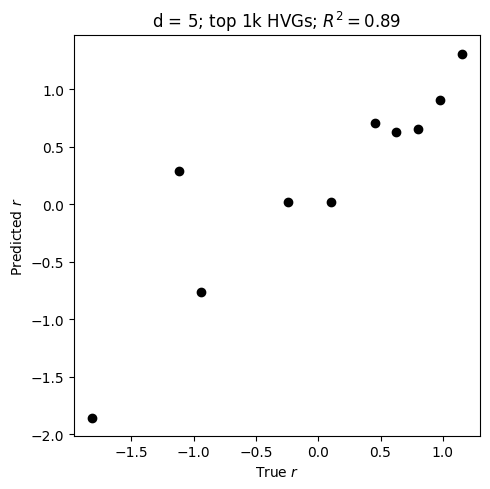

In [11]:
plt.figure(figsize=(5, 5))
plt.subplot()
plt.scatter(R, preds, c="black")
plt.xlabel(r"True $r$")
plt.ylabel(r"Predicted $r$")
plt.title(r"d = 5; top 1k HVGs; $R^2 = " + str(round(r2_contrastivereg, 2)) + "$")

plt.tight_layout()
plt.show()

In [14]:
# check latent factor t
latent_t = onp.asarray(model.t)
asd_sample = score['sample'][score['diagnosis']=='ASD'].to_list()
dims = ["Dim%d" % i for i in range(1,9)]

In [15]:
loading_w = pd.DataFrame(model.W, columns = df.index.to_list(), index = dims,dtype = "float")
pyreadr.write_rds(output_dir + 'W.rds', loading_w, compress="gzip")
print(loading_w.head())

      RP5-857K21.4  MTND1P23  MTND2P28  RP5-857K21.6  MTATP6P1     ACAP3  \
Dim1      0.023808 -0.060882  0.085854     -0.104276  0.149034  0.039738   
Dim2     -0.008068 -0.012827 -0.008462     -0.046243  0.124219  0.069611   
Dim3      0.002869  0.035223  0.005729      0.025546  0.185139 -0.004319   
Dim4     -0.087081 -0.000241  0.019346      0.003606 -0.459906 -0.154044   
Dim5      0.032395 -0.046573 -0.004006     -0.057603  0.044529  0.044058   

         GABRD      CHD5      ENO1    CLSTN1  ...  MAPK8IP2   TEKT4P2  \
Dim1  0.053198  0.027205  0.042278  0.159238  ...  0.033725  0.033382   
Dim2  0.084497  0.069135  0.078725  0.229275  ...  0.046291 -0.036288   
Dim3  0.035308  0.031694  0.080156  0.178209  ...  0.041261  0.026813   
Dim4 -0.117107 -0.255452 -0.039579 -0.278430  ... -0.092118 -0.004709   
Dim5 -0.011482  0.028098 -0.028387  0.026258  ... -0.028933  0.000736   

      bP-21201H5.1  ANKRD20A11P  MIR99AHG     ATP5J       APP      SOD1  \
Dim1      0.019167    -0.0164

In [16]:
latent_t = pd.DataFrame(model.t, columns = dims, index = asd_sample, dtype="float")
pyreadr.write_rds(output_dir + 't.rds', latent_t, compress="gzip")
print(latent_t.head())

              Dim1      Dim2      Dim3      Dim4      Dim5      Dim6  \
5144_PFC -0.489170  0.150458  0.850076 -0.404951  1.012822  0.643878   
5278_PFC -0.038157 -0.223055  0.799881  0.594321  0.147289 -0.430833   
5294_BA9 -0.264539 -0.020684 -0.089406 -0.002940  0.267508  0.068198   
5403_PFC  0.879480  0.097651  0.107662 -0.369426  0.581738 -0.325037   
5419_PFC -0.642341  0.967048  0.166970  0.708298 -0.011974 -0.580594   

              Dim7      Dim8  
5144_PFC  0.205108 -0.315745  
5278_PFC  0.125301  0.044253  
5294_BA9 -0.060507 -0.059063  
5403_PFC  0.543243  0.605976  
5419_PFC  0.922552 -0.465222  


In [17]:
pyreadr.write_rds(output_dir + 'beta.rds', pd.DataFrame(data=model.beta), compress="gzip")

In [18]:
auxiliary_s = pd.DataFrame(model.S, columns = df.index.to_list(), index = dims, dtype="float")
print(auxiliary_s.head)
pyreadr.write_rds(output_dir + 'S.rds', auxiliary_s, compress="gzip")

<bound method NDFrame.head of       RP5-857K21.4  MTND1P23  MTND2P28  RP5-857K21.6  MTATP6P1     ACAP3  \
Dim1     -0.037910  0.041754 -0.009299      0.085125 -0.179107 -0.003021   
Dim2     -0.048880 -0.031582  0.000132     -0.024325 -0.171854 -0.146309   
Dim3     -0.013287  0.036452 -0.006965      0.073485 -0.021303 -0.015805   
Dim4     -0.044452 -0.113255 -0.005686     -0.153997 -0.116202 -0.078431   
Dim5      0.100510 -0.042455  0.008772     -0.026527  0.281305  0.131859   
Dim6     -0.007162 -0.034458 -0.004527     -0.056833 -0.067506  0.012824   
Dim7     -0.007553 -0.020172  0.000943     -0.022395 -0.035636 -0.022273   
Dim8      0.017471 -0.057954  0.003061     -0.102513  0.026976 -0.012683   

         GABRD      CHD5      ENO1    CLSTN1  ...  MAPK8IP2   TEKT4P2  \
Dim1  0.036058 -0.023141  0.027935  0.103129  ... -0.004801  0.003559   
Dim2 -0.068957 -0.194022 -0.037605 -0.163373  ... -0.042712  0.027390   
Dim3 -0.002721 -0.039434 -0.012956 -0.028390  ... -0.013797 -0.044

In [19]:
## sort by absolute value of beta
beta = onp.array(model.beta.T.flatten())
print(beta)
indices = onp.argsort(abs(beta))
max_abs_beta_index = indices[-1] # start from 0
target_dim = 'Dim' + str(max_abs_beta_index + 1)
print('Dimension with largest absolute value of beta: ' + target_dim)

[-0.2825892   1.6514705   0.26765734 -0.75194407  1.269176   -1.2952262
 -1.5379503   1.2674844 ]
Dimension with largest absolute value of beta: Dim2


In [20]:
## sort gene (w)
w_d = loading_w.loc[[target_dim]].T
w_d['gene'] = w_d.index.values.tolist()
sorted_w_d = w_d.sort_values(by=target_dim, ascending=False)
sorted_w_d['rank'] = list(range(1,w_d.shape[0]+1))
sorted_w_d.to_csv(output_dir + 'gene_rank_max_abs_beta.csv', index = False)

sorted_w_d

,Dim2,gene,rank
MALAT1,1.580847,MALAT1,1
RASGEF1B,1.007793,RASGEF1B,2
LINC00486,0.927019,LINC00486,3
CADM2,0.819619,CADM2,4
PCDH9,0.815199,PCDH9,5
...,...,...,...
CH17-472G23.2,-0.054079,CH17-472G23.2,996
DCC,-0.058617,DCC,997
RP11-449D8.5,-0.070198,RP11-449D8.5,998
RP11-236F9.2,-0.086003,RP11-236F9.2,999
